# Análise de Jira Sprints

O arquivo a ser processado é exportado através do filtro "Exportar issues_análise"no Jira LabCoMU
- Definir opção XML


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import xml.etree.ElementTree as ET
import dfParser as dp
import xmlParser as xp
import items_utils as iu

### Especificações manuais necessárias:
- Incremente a lista de sprints e suas respectivas datas no dicionário sprint_dates

In [3]:
sprint_dates = {
    'Izy - Cycle 24.1 Sprint 0': {'start': '07/11/24', 'end': '21/11/24'},
    'Izy - Cycle 24.1 Sprint 1': {'start': '19/11/24', 'end': '02/12/24'},
    'Izy - Cycle 24.1 Sprint 2': {'start': '03/12/24', 'end': '16/12/24'},
    'Izy - Cycle 24.1 Sprint 3': {'start': '16/12/24', 'end': '27/12/24'},
    'Izy - Cycle 24.1 Sprint 4': {'start': '07/01/25', 'end': '20/01/25'},
    'Izy - Cycle 24.1 Sprint 5': {'start': '21/01/25', 'end': '03/02/25'},
}

- Especifique o nome da sprint ativa

In [5]:
sprint_ativa = 'Izy - Cycle 24.1 Sprint 5'

- Especifique o arquivo csv na variável file_path

In [6]:
# Carregar o arquivo enviado
file_path = 'xmls/sprint.xml'

parsed_items = xp.loadXml(file_path)

- Revise a lista de feriados no período.

In [7]:
feriados = {
    'Véspera de Natal': '24/12/24',
    'Natal': '25/12/24'
}

In [8]:
df_geral = dp.prepare_df(parsed_items)

df = iu.filter_sprint_ativa(df_geral, sprint_ativa)

sprints_df = iu.prepare_sprints_df(sprint_dates)

feriados_df = iu.prepare_feriados_df(feriados)

/Users/eliezio/Projects/labcomu/JiraSprintAnalysis/dfParser.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['data_criacao'].replace('', '01/01/70 00:00:00', inplace=True)
/Users/eliezio/Projects/labcomu/JiraSprintAnalysis/dfParser.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as

# Itens x Status

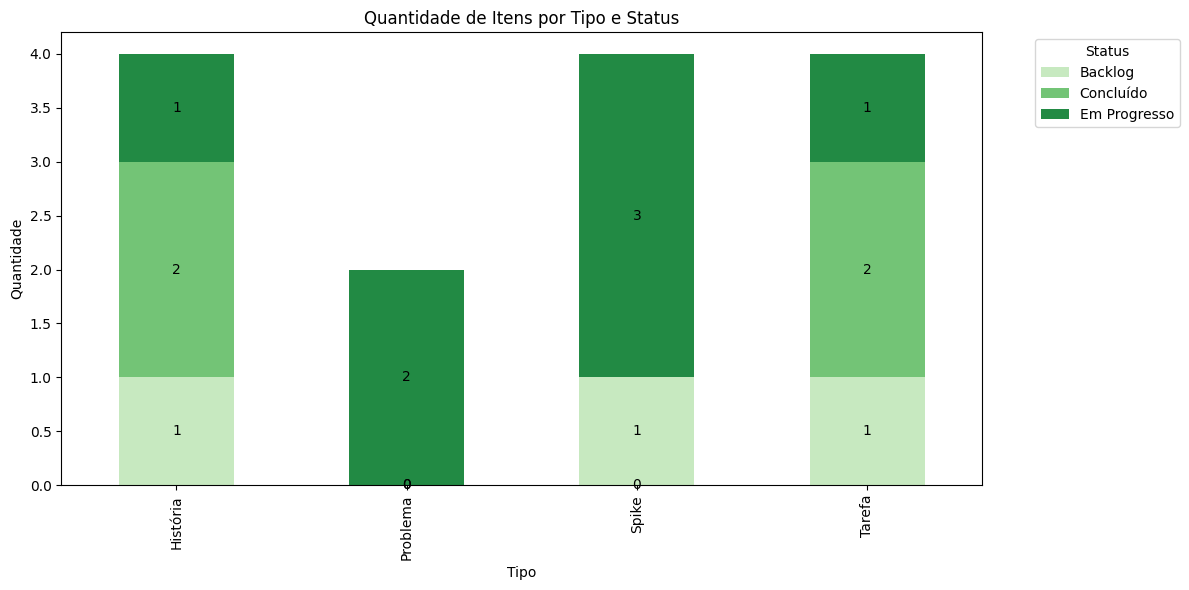

In [9]:
items_simplified = iu.filter_items(df).copy()
# Apply the status mapping
items_simplified['status'] = items_simplified['status'].apply(iu.simplify_status)

# Create pivot table with simplified status, ensure counts are integers
pivot_simplified = pd.crosstab(items_simplified['tipo'], items_simplified['status']).astype(int)

# Generate a color palette with more variations
colors = sns.color_palette("Greens", n_colors=len(pivot_simplified.columns))

# Re-plot the stacked bar chart with the new color palette
ax = pivot_simplified.plot(kind='bar', stacked=True, figsize=(12,6), color=colors)

# Add value labels on the bars
for c in ax.containers:
    ax.bar_label(c, label_type='center')

plt.title('Quantidade de Itens por Tipo e Status')
plt.xlabel('Tipo')
plt.ylabel('Quantidade')
plt.legend(title='Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Subtasks

In [11]:
# Get subtasks using filter_subitems
subtasks = iu.filter_subitems(df)
subtask_count = subtasks['status'].value_counts()
total_subtasks = len(subtasks)

# Display the counts
print(f"Total de sub-tasks: {total_subtasks}")
print("\nQuantidade de sub-tasks por status no escopo da sprint:")
print(subtask_count)

Total de sub-tasks: 51

Quantidade de sub-tasks por status no escopo da sprint:
status
Concluída       34
Backlog         10
Em Andamento     3
Code Review      2
Needs Test       1
In Test          1
Name: count, dtype: int64


In [12]:
# Obter as datas de início e fim da sprint ativa
sprint_start = sprints_df.loc[sprint_ativa, 'start']
sprint_end = sprints_df.loc[sprint_ativa, 'end']

# Filtrar sub-tasks criadas dentro do período da sprint ativa usando a função filter_subitems
subtasks_created = iu.filter_subitems(df_geral[
    (df_geral['data_criacao'] >= sprint_start) &
    (df_geral['data_criacao'] <= sprint_end)
])

# Filtrar sub-tasks finalizadas dentro do período da sprint ativa
subtasks_completed = iu.filter_subitems(df_geral[
    (df_geral['data_resolucao'] >= sprint_start) &
    (df_geral['data_resolucao'] <= sprint_end)
])

# Contabilizar o número de sub-tasks criadas e finalizadas
num_subtasks_created = len(subtasks_created)
num_subtasks_completed = len(subtasks_completed)

print(f"Sub-tasks criadas na {sprint_ativa}: {num_subtasks_created}")
print(f"Sub-tasks finalizadas na {sprint_ativa}: {num_subtasks_completed}")

Sub-tasks criadas na Izy - Cycle 24.1 Sprint 5: 29
Sub-tasks finalizadas na Izy - Cycle 24.1 Sprint 5: 20


<Figure size 1200x600 with 0 Axes>

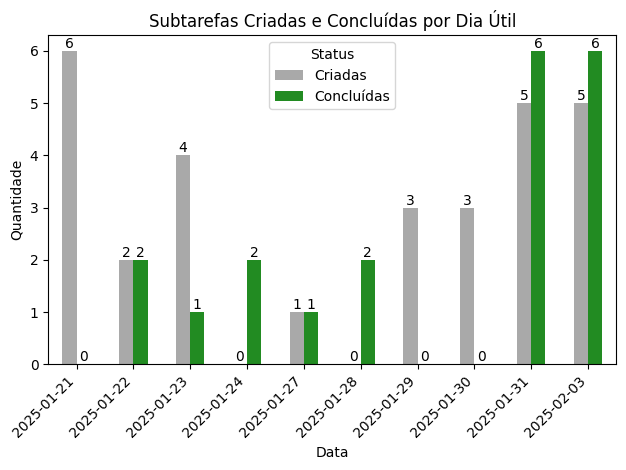

In [13]:
# Create a date range for working days (Monday to Friday)
date_range = pd.date_range(start=sprint_start, end=sprint_end, freq='B').strftime('%Y-%m-%d')

# Remove feriados do date range
holidays = pd.to_datetime(feriados_df[0])
date_range = date_range.difference(holidays)

# Initialize dictionaries to store counts per day
created_per_day = {date: 0 for date in date_range}
completed_per_day = {date: 0 for date in date_range}

# Count subtasks created and completed per day
for date in date_range:
    created_per_day[date] = len(subtasks_created[subtasks_created['data_criacao'] == pd.to_datetime(date).date()])
    completed_per_day[date] = len(subtasks_completed[subtasks_completed['data_resolucao'] == pd.to_datetime(date).date()])

# Create DataFrame for plotting
plot_data = pd.DataFrame({
    'Criadas': created_per_day.values(),
    'Concluídas': completed_per_day.values()
}, index=date_range)

# Create the plot
plt.figure(figsize=(12, 6))
ax = plot_data.plot(kind='bar', color=['#A9A9A9', '#228B22'])  

# Customize the plot
plt.title('Subtarefas Criadas e Concluídas por Dia Útil')
plt.xlabel('Data')
plt.ylabel('Quantidade')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Status')

# Add value labels on top of bars
for container in ax.containers:
    ax.bar_label(container)

plt.tight_layout()


<Figure size 1200x600 with 0 Axes>

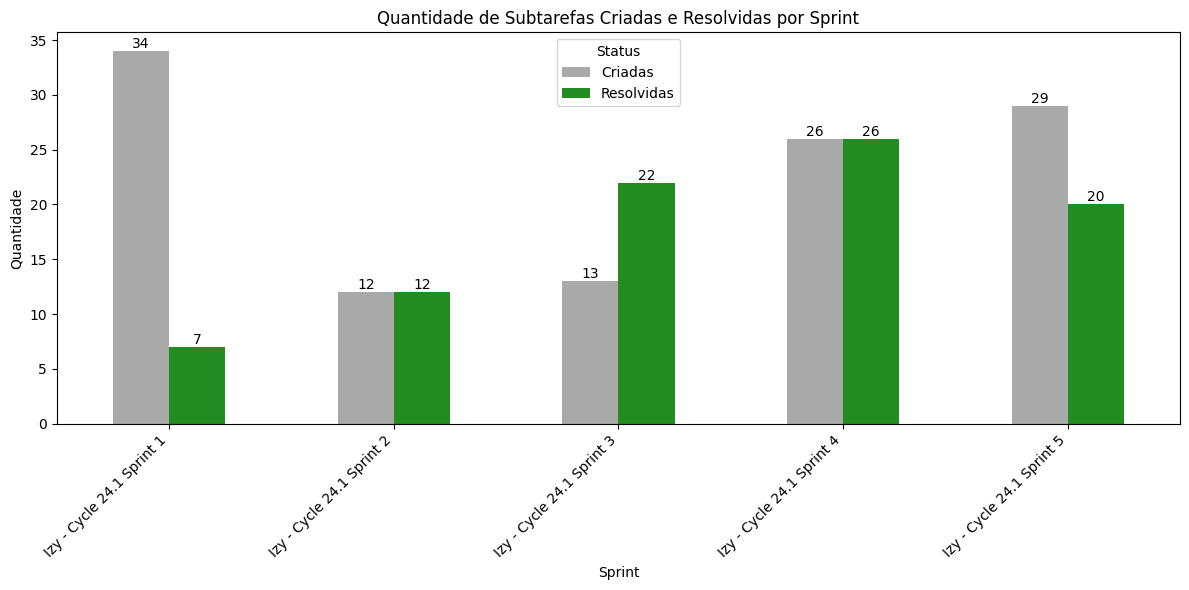

In [20]:
# Filtrar subtarefas criadas e resolvidas por sprint
subtasks_created_by_sprint = pd.Series(dtype=int)
subtasks_resolved_by_sprint = pd.Series(dtype=int)

for sprint, dates in sprints_df.tail(5).iterrows():
    start_date = dates['start']
    end_date = dates['end']
    
    created_count = iu.filter_subitems(df_geral[
        (df_geral['data_criacao'] >= start_date) &
        (df_geral['data_criacao'] <= end_date)
    ]).shape[0]
    
    resolved_count = iu.filter_subitems(df_geral[
        (df_geral['data_resolucao'] >= start_date) &
        (df_geral['data_resolucao'] <= end_date)
    ]).shape[0]
    
    subtasks_created_by_sprint[sprint] = created_count
    subtasks_resolved_by_sprint[sprint] = resolved_count

# Criar um DataFrame com as contagens
subtasks_by_sprint = pd.DataFrame({
    'Criadas': subtasks_created_by_sprint,
    'Resolvidas': subtasks_resolved_by_sprint
}).fillna(0).astype(int)

# Plotar o gráfico
plt.figure(figsize=(12, 6))
ax = subtasks_by_sprint.plot(kind='bar', figsize=(12, 6), color=['#A9A9A9', '#228B22'])

# Personalizar o gráfico
plt.title('Quantidade de Subtarefas Criadas e Resolvidas por Sprint')
plt.xlabel('Sprint')
plt.ylabel('Quantidade')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Status')

# Adicionar rótulos de valor nas barras
for container in ax.containers:
    ax.bar_label(container)

plt.tight_layout()
plt.show()

# Velocidade da Sprint

Sprint: Izy - Cycle 24.1 Sprint 5
Total de Story Points: 41.0
Story Points Concluídos: 12.0
Média de Story Points Concluídos por Sprint: 16.4
Mediana de Story Points Concluídos por Sprint: 11.0
Desvio Padrão de Story Points Concluídos por Sprint: 22.72223580548358






/var/folders/m5/937z77hn3_jg_c963gpdx5fh0000gn/T/ipykernel_30720/3002209202.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  completed_items['story_points'] = completed_items['story_points'].replace('', '0').astype(float)
/var/folders/m5/937z77hn3_jg_c963gpdx5fh0000gn/T/ipykernel_30720/3002209202.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sprint_items['story_points'] = sprint_items['story_points'].replace('', '0').astype(float)
/var/folders/m5/937z77hn3_jg_c963gpdx5fh0000gn/T/ipykernel_30720/3

<Figure size 1200x600 with 0 Axes>

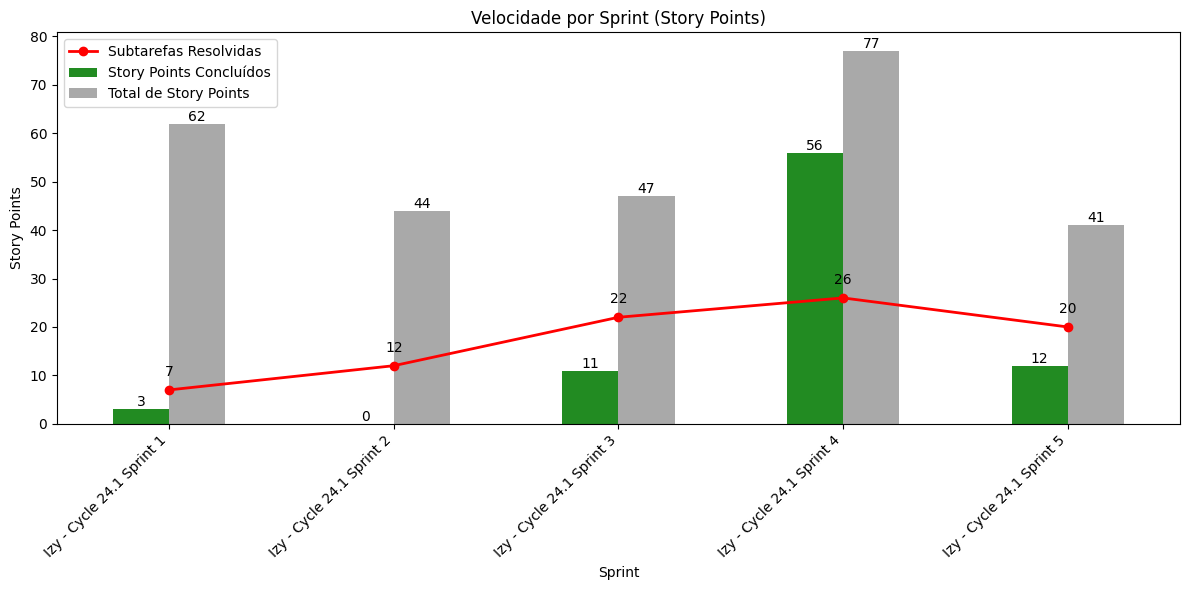

In [21]:
# Filtrar itens finalizados por sprint e somar os story points
velocity_by_sprint = pd.Series(dtype=float)
total_points_by_sprint = pd.Series(dtype=float)

for sprint, dates in sprints_df.tail(5).iterrows():
    start_date = dates['start']
    end_date = dates['end']
    
    # Filtrar itens da sprint da iteração
    sprint_items = iu.filter_sprint_ativa(df_geral, sprint)

    # Filtrar itens finalizados dentro do período da sprint
    completed_items = df_geral[
        (df_geral['data_resolucao'] >= start_date) &
        (df_geral['data_resolucao'] <= end_date) &
        (df_geral['status'] == 'Concluída')
    ]
    
    # Limpar e converter os story points para float
    completed_items['story_points'] = completed_items['story_points'].replace('', '0').astype(float)
    total_story_points = completed_items['story_points'].sum()
    velocity_by_sprint[sprint] = total_story_points

    # Limpar e converter os story points para float
    sprint_items['story_points'] = sprint_items['story_points'].replace('', '0').astype(float)
    total_points = sprint_items['story_points'].sum()
    total_points_by_sprint[sprint] = total_points

# Criar um DataFrame com as contagens
velocity_df = pd.DataFrame({
    'Story Points Concluídos': velocity_by_sprint,
    'Total de Story Points': total_points_by_sprint
}).fillna(0).astype(float)

# Imprimir dados da última sprint
print(f"Sprint: {sprint_ativa}")
print(f"Total de Story Points: {total_points_by_sprint[sprint_ativa]}")
print(f"Story Points Concluídos: {velocity_by_sprint[sprint_ativa]}")

# Calcular e imprimir a média e a mediana da velocity_by_sprint
mean_velocity = velocity_by_sprint.mean()
median_velocity = velocity_by_sprint.median()

print(f"Média de Story Points Concluídos por Sprint: {mean_velocity}")
print(f"Mediana de Story Points Concluídos por Sprint: {median_velocity}")
print(f"Desvio Padrão de Story Points Concluídos por Sprint: {velocity_by_sprint.std()}")
print('\n\n\n')

# Plotar o gráfico
plt.figure(figsize=(12, 6))
ax = velocity_df.plot(kind='bar', figsize=(12, 6), color=['#228B22', '#A9A9A9'])

# Adicionar linha vermelha representando subtarefas resolvidas por sprint
ax.plot(subtasks_resolved_by_sprint.index, subtasks_resolved_by_sprint.values, color='red', marker='o', linestyle='-', linewidth=2, label='Subtarefas Resolvidas')

# Adicionar rótulos de valor na linha
for i, txt in enumerate(subtasks_resolved_by_sprint.values):
    ax.annotate(txt, (subtasks_resolved_by_sprint.index[i], subtasks_resolved_by_sprint.values[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Personalizar o gráfico
plt.title('Velocidade por Sprint (Story Points)')
ax.set_xlabel('Sprint')
ax.set_ylabel('Story Points')
ax.set_xticklabels(velocity_df.index, rotation=45, ha='right')

# Adicionar rótulos de valor nas barras
for container in ax.containers:
    ax.bar_label(container)

# Adicionar legenda
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()


/var/folders/m5/937z77hn3_jg_c963gpdx5fh0000gn/T/ipykernel_60035/499040048.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (plot_data.index[i], work_remaining[i]), textcoords="offset points", xytext=(0,10), ha='center')


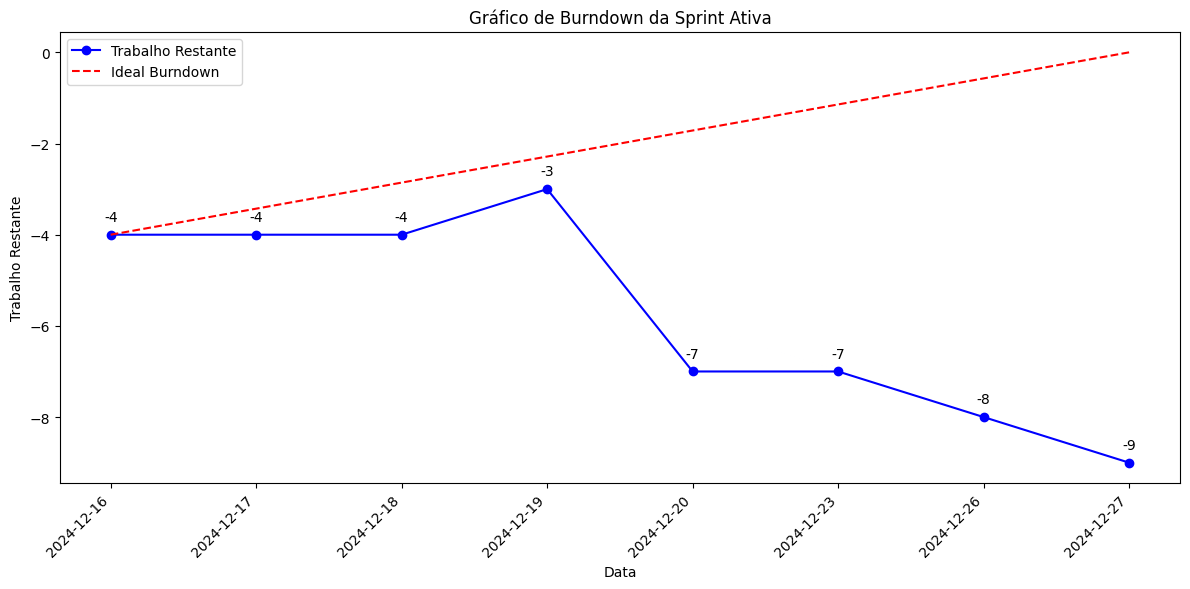

In [244]:
# Calcular o trabalho restante por dia
work_remaining = plot_data['Criadas'].cumsum() - plot_data['Concluídas'].cumsum()

# Criar o gráfico de burndown
plt.figure(figsize=(12, 6))
plt.plot(plot_data.index, work_remaining, marker='o', linestyle='-', color='blue', label='Trabalho Restante')

# Adicionar linha de ideal burndown
ideal_burndown = [work_remaining.iloc[0] - (work_remaining.iloc[0] / (len(work_remaining) - 1)) * i for i in range(len(work_remaining))]
plt.plot(plot_data.index, ideal_burndown, linestyle='--', color='red', label='Ideal Burndown')

# Personalizar o gráfico
plt.title('Gráfico de Burndown da Sprint Ativa')
plt.xlabel('Data')
plt.ylabel('Trabalho Restante')
plt.xticks(rotation=45, ha='right')
plt.legend()

# Adicionar rótulos de valor nos pontos
for i, txt in enumerate(work_remaining):
    plt.annotate(txt, (plot_data.index[i], work_remaining[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()